## Download **MNIST** dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print (X.shape, y.shape)

(70000, 784) (70000,)


`X` as shape (70.000, 784) meaning there are 70.000 images each of 28x28 size resulting in 784 each feature represents a pixel's intensity from 0 (white) to 255 (black)

`y` as shape (70.000) a tag for each picture

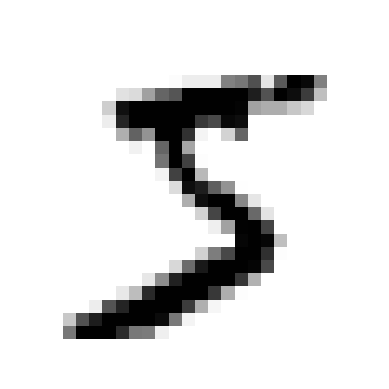

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.colormaps['binary'], interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

the first element is a 5

In [10]:
import numpy as np

y = y.astype(np.uint8)  # let's transform from string to int
y[0]

np.uint8(5)

## Split train/test sets

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is **already shuffled** for us, which is good as this guarantees that all `cross-validation` folds will be similar (you don’t want one fold to be missing some digits). 

Moreover, some learning algorithms are **sensitive** to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

## Training a Binary Classifier

Let's create a create a model that only detect if 5 or not. For that we will use the `Stochastic Gradient Descent (SGD)` classifier

The SGD has the following advantages:
- Handles a very large dataset very efficiently (because deals with training instances independently, one at a time)
- Well suited for *online training* becouse of the previous reason

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

# SSGDClassifier relies on randomness during training (hence stochastic)
# to create more reproducible results we set a `random_state` 
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance Measures

Evaluating a **Classifier** is more complex than a **Regressor**. And there are many methods

### Measuring Accuracy using **Cross-Validation**

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

over 95% accuracy

#### Manual Implementing **Cross-Validation**

Seems like somethings it is better to have more control over the cross-validation that Scikit-Learn provides. The following is a manual impl of the K-folds cross-validation

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # to ensure each fold uses a fresh model
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495

0.9669
0.91625
0.96785


#### Why accuracy perf mersure is not the usefull sometimes?

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): pass
    def predict(self, X): 
        return np.zeros((len(X), 1), dtype=bool)


never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

above 90% every time, this is because only 10% of the images are 5s. So if you guess an image is not a 5 you will be right 90% of the time

### Confusion Matrix

The idea is to count the number of times instances of class A are classified as class B

We need to compare a set of prediction with the actual targets

In [18]:
from sklearn.model_selection import cross_val_predict

# instead of _score(), _predict() performs k-fold cross-validation 
# but instead of returning the evaluation scores, it returns the predictions 
# made on each test fold 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

each row represents a class, each column a predicted class

row 1: represents actual    **non-5s** (negative class) \
row 2: represents actual    **5s** (positive class) \
col 1: represents predicted **non-5s** \
col 2: represents predicted **5s**

53,892 are correctly classified non-5s (true negatives) \
687 are incorrectly classified 5s (false positives) \
1,891 are incorrectly classified non-5s (false negatives) \
3,530 are correctly classified 5s (true positives)

### Precision & Recall

[Precision vs Recall - Youtube](https://www.youtube.com/watch?v=qWfzIYCvBqo)


One important metric that can be calculated from a confusion matrix is the called **precision of the classifier**, this is based upon the **accuracy of the positive predictions** 
$$\text{precision} = \frac{TP}{TP + FP}$$
$TP$: number of true positives \
$FP$: number of false positives

**precision** is typically used with another metric named **recall** (or sensitivity or true positive rate)
$$\text{recall} = \frac{TP}{TP + FN}$$
$FN$: number of false negatives 

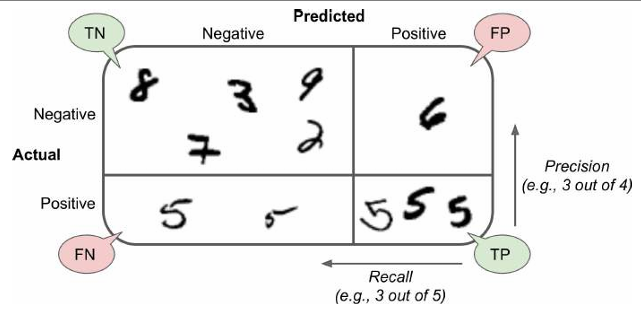

In [20]:
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred) # = 4096 / (4096 + 687)

np.float64(0.8370879772350012)

In [21]:
from sklearn.metrics import recall_score
recall_score(y_train_5, y_train_pred) # = 4096 / (4096 + 1891)

np.float64(0.6511713705958311)

now when it claims an image is a 5, its correct only 83% of the time
and it only detect the 65% of the 5s

Its often convinient to combine precision and recall into a single metric called $F_1$ score.

$F_1$ is the harmonic mean of precision and recall (in difference with normal mean, it gives much more weight to low values)

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = \frac{\text{precision} * \text{recall}}{\text{precision} + \text{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

**The classifier will only get a high $F_1$ score if both recal and precision are high**

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

The $F_1$ score works well when precision and recall are similar. Sometimes you need a more higher precision or much higher recall

**Precision** is crucial when the cost of false positives is high. For example, in your video classifier scenario, you want to ensure that only safe videos are shown to kids, even if it means rejecting some good ones.

**Recall** is essential when the cost of false negatives is high. In the shoplifter detection example, you want to catch as many shoplifters as possible, even if it means some false alerts.

To address this **tradeoff**, you can adjust the decision threshold of your classifier or use different evaluation metrics that align with your specific needs. For instance, you might use Precision-Recall curves to visualize the tradeoff and choose an optimal threshold.

### Precision/Recall Tradeoff

the `SGDClassifier` computes for each instance, a score based on a **decision function**, and threshold indicates where the instance will be assigned, the positive o negative class. 

Sadly this threshold can be changed instead of calling the classifier's `predict()`, you can call its `decision_function()` method, which returns a score for each instance, and then you can make predictions based on those scores using any threshold you want

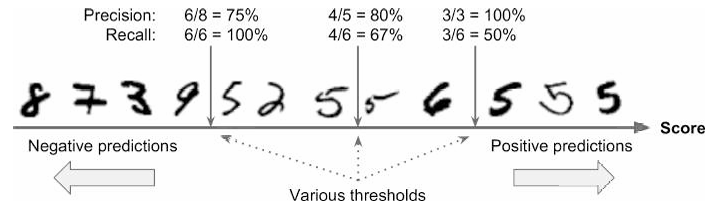

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0  # default SGDClassifier uses
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [24]:
threshold = 8000  # much more bigger threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

this image is an actual 5, with the threshold in 0 it detect it, but when increased it not longer detects it as a 5, decreasing the **recall**

#### What threshold to use?

1. get the **decision scores** instead of the predictions of all instances in the training set using `cross_val_predict()` 
2. then compute precision and recall for all possible thresholds using `precision_recall_curve()`
3. plot precision and recall as functions of the threshold

In [25]:
from sklearn.metrics import precision_recall_curve

# 1.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function')

# 2.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

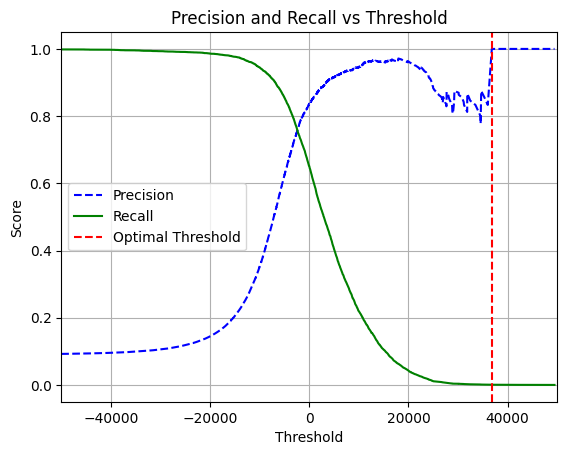

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend(loc="best")
    plt.grid(True)
    plt.axvline(x=thresholds[np.argmax(precisions)], color='r', linestyle='--', label='Optimal Threshold')
    plt.xlim(-50000, 50000)  # Set x-axis limits
    plt.legend()
    plt.show()

# 3. 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

let's suppose you decide to aim for **90%** precision.

One way is to look at the above plot and find that you need a threshold of about 8,000. \
Other more precise way is to use `np.argmax()` which gives you the first index of the maximum value 

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # ~3370
#                                   ^ in this case the idx of the first True
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [29]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

A high-precision classifier is not very useful if its recall is too low!

### The ROC Curve


The **receiver operating characteristic** is a common tool used with **binary classifiers**. It's usefull when comparing two distinct classifiers 

Its similar to precision/recall curve but instead it plots **true positive rate** (recall) vs **false positive rate**

**FPR** (false positive rate): is the ratio of negative instances that are incorrectly classified as positive $\text{FPR} = 1 - \text{true negative rate}$

**TNR** (true negative rate / specificity): which is the ratio of negative instances that are correctly classified as negative

ROC plots sensivility (recall) vs 1 - specificity 

C:\Users\strange\AppData\Local\Temp\ipykernel_4860\189056430.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


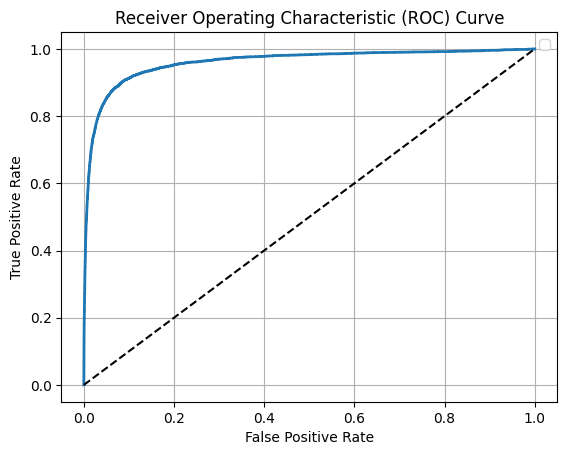

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_roc_curve(fpr, tpr)

there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to **compare classifiers** is to measure the *area under the curve* (AUC).
- A perfect classifier will have a ROC AUC = 1
- A purely random classifier will have a ROC AUC = 0.5

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In this example, the previous ROC curve (and the ROC AUC score) indicates that the classifier is really good (96%), but this is mostly because there are few positives (5s) compared to the negatives (non-5s)

The precision/recall (PR) curve makes it clear that the classifier can be improved further (the curve could be closer to the top-right corner)


**When ROC or precision/recall?**

You prefer the *PR* curve whenever 
    - the positive class is rare or
    - when you care more about the false positives than the false negatives

And ROC curve otherwise.




#### `RandomForestClassifier` vs `SGDClassifier`

Let's train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to the `SGDClassifier`. First we need the scores of each instance in the training set

`RandomForestClassifier` does not have a `decision_function()` instead it has `dict_proba()`. (Sklearn generally has one or the other)

`predict_proba()` -> array([]) containing a column per class in each instance with the **probability** that the given instance belongs to the given class

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict_proba')

# for the ROC curve we need scores not probability. 
# we can use the positive class's probability as the score
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

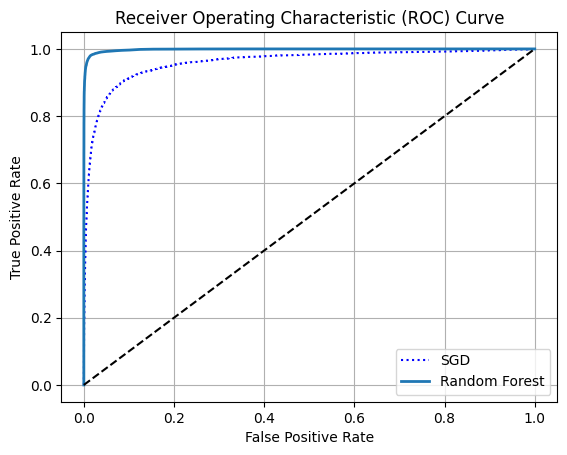

C:\Users\strange\AppData\Local\Temp\ipykernel_4860\3523997786.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


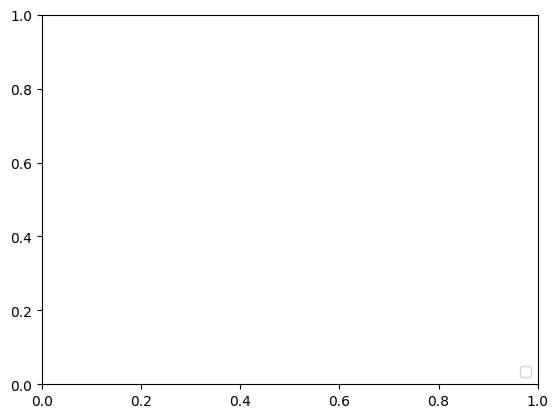

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

Random Forest seems to work much better than SGD Classifier

## Multiclass Classification

Some algorithms like **Random Forest classifiers** or **naive Bayes classifiers** are capable of handling multiple classes directly 

Others like **Support Vector Machine** or **Linear classifiers** are strictly binary classifiers

There are 2 main ways to classify the digit images into 10 classes (0 -> 9)
- **OvA** (one-versus-all): train 10 **binary classifiers**, one for each digit (a 0-detector, 1-detector, ...). 
    - Then you get the decision score for each image and select the class with the highest score.

- **OvO** (one-versus-one): train a binary classifier for every pair of digits: (one to distinguish 0s and 1s, 0s and 2s, 1s and 2s, ...). 
    - For $N$ classes you need $\frac{N(N-1)}{2}$ classifiers. 
    - For the MNIST problem this means 45 binary classifiers. 
    - When you want to classify and image you run the image through all classifiers and see which class wins the most duels
    - The main **advantage** of OvO is that each classifier only needs to be trained on the subset of the training set for the two classes it must distinguish
    - **preferred** for algorithms like **Support Vector Machines** that doesn't scale well with the size of the training set, OvO is preferred since its faster to train many classifiers on small training sets than a few classifiers on large training sets


In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [37]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
sgd_clf.classes_[3]  # this don't always match 

3
[0 1 2 3 4 5 6 7 8 9]


np.uint8(3)

the highest score is indeed the class 3

You can force Sklearn to use **one-versus-one** or **one-versus-all** strategy

In [38]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [39]:
len(ovo_clf.estimators_)

45

Training a `RandomForestClassifier`

This algo does not uses OvA or OvO because it can directly classify instances into multiple classes

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
forest_clf.predict_proba([some_digit])

g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

The model estimates a 90% of probability that the image is a 5, but also thinks the image could be a 2, 3, 9 with 1%, 8%, 1% probability

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

over 85% on all tests folds. Not bad. It could be improved up to 89% simply by scaling the inputs

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

## Error Analysis

Now one way to improve our model is to analyze the types of errors it makes

For that we can analyze the **confusion matrix**

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [4]:
plt.matshow(conf_mx, cmap=mpl.colormaps['gray'])
plt.show()

NameError: name 'conf_mx' is not defined

Looks good, since most images are on the main diagonal (meaning that images where correctly classified).

The 5s look a bit darker than the rest wich could mean that:
- There are fewer images of 5s 
- The classifier does not perform as well on 5s as on other digits

Let's focus the plot on the errors.
First we need to compare the number of errors between each class. One problem is that some classes have a more greater proporcion and could be unfair to compare the amount of errors, we instead compare the rate of errors

In [46]:
# error rate = each value of conf_mat / number of images of the class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

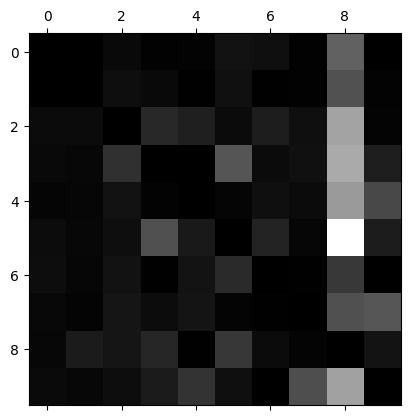

In [47]:
np.fill_diagonal(norm_conf_mx, 0) # to only keep the errors
plt.matshow(norm_conf_mx, cmap=plt.colormaps['gray'])
plt.show()

Seems like most of the errors is when the model is mis-predicting a lot of **8s**, however the row for class 8 is not that bad, telling us that 8s are correctly classified but a lot of other numbers were predicted as 8s.

**3s** and **5s** also often get confused in both directions

So efforts would be center on **fixing the 8s predictions**:
- We could try gather more training data for digits similar to 8s, so the classifier can learn to distinguish them
- Or engineer new features to help the classifier:
    e.g. write an algo to count the number of closed loops (8 has 2, 6 has 1, 5 has 0)
- Preprocess the images to make some patterns stand out more, like closed loops (using Scikit-Image, Pillow, OpenCV)

We can also analyze individual errors to gain more insights

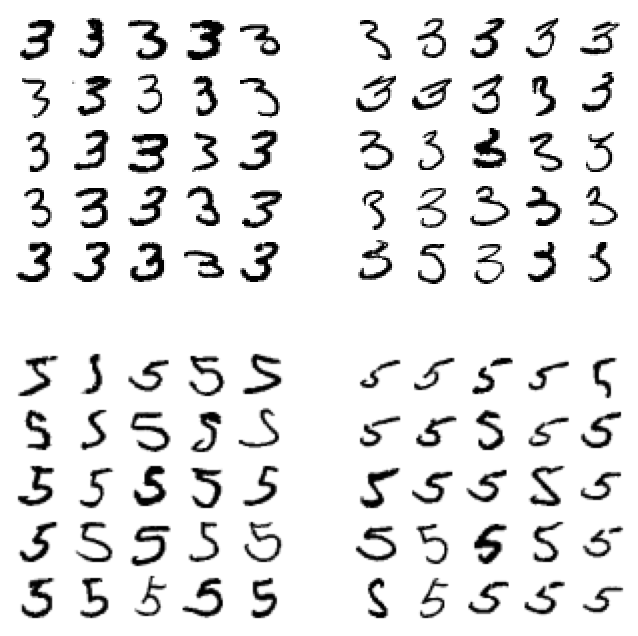

In [50]:
import numpy as np
import matplotlib.pyplot as plt


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate(
        [instances, np.zeros((n_empty, size * size))], axis=0
    )

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(
        n_rows * size, images_per_row * size
    )
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.colormaps['binary'], **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()


the first two 5x5 blocks are digits classified as 3s, and the other 5x5 blocks are images classified as 5s

The reason for the most of the errors are because **the model is too simple**.

`SGDClassifier` is a linear model. All it does is to assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class

**3** and **5** mainly differ in the small line that joins the top line to the bottom arc, so if this line is shifted to the left the model htinks is a 5 and vice versa. So one way to reduce the 3/5 confusion is to preprocess the images to ensure they are well centered and not too rotated

## Multilabel Classification

Sometimes you need multiple labels as the outputm, e.g. face-recognition when you will have multiple faces that you want your model to tag.

If your classifier has been trained to recognize three faces, Alice, Bob, and Charlie then where it is shown a picture of Alice and Charlie, it should output [1, 0, 1], (Alice yes, Bob no, Charlie yes)

In [52]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

it correctly predicts that the 5 is not large (False) and odd (True)

**How to evaluate a Multilable Classifier?**

- you could use the $F_1$ score for each individual label (or other binary classifier metric) and compute the average score 

In [53]:
# compute the average F1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

Calculating the average $F_1$ score as above assumes all labels are equally important. 

If not the case, (e.g. there aren't equal amount of instances for each class), need to give different weights according with the proporcion. A simple way to do this is to give each label a weight equal to its *support* (i.e. the number of instances with that target label), for that you simply has to set `average="weighted"`

## Multioutput Classification

also called **Multioutput Multiclass Classification**

It's a generalization of multilabel classification where each label can be multiclass (can have more than two possible values)

The following is a system for **noise removal from images**. It takes a noise image and output a clean digit image represented by and array of pixel intensities, just like the MNIST images 

In this case the classifier output is multilabel (each label is represented with a pixel), and each label can have multiple values (that represent intensity from 0-255)

In [54]:
# add noise to the training set
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 

# add noise to the test set
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise 

# the original sets are now the labels
y_train_mod = X_train
y_test_mod = X_test

In [84]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.colormaps['binary'], interpolation="nearest")
    plt.axis("off")

some_digit_mod = np.array(X_test_mod.iloc[6]) 
some_digit_clean = np.array(y_test_mod.iloc[6])

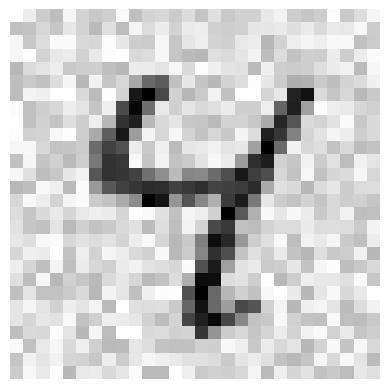

In [85]:
# noise image
plot_digit(some_digit_mod)

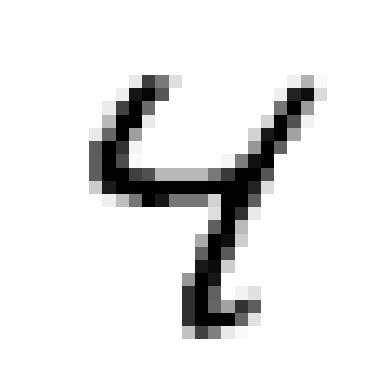

In [86]:
# clean image
plot_digit(some_digit_clean)

predicted image

g:\projects\ml\mnist-classification\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


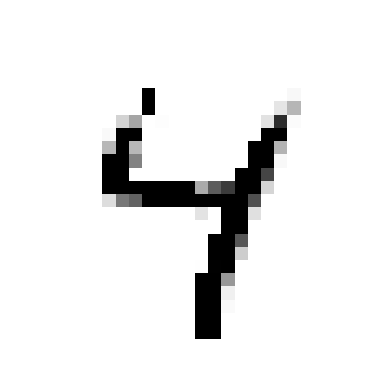

In [87]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_digit_mod])
plot_digit(clean_digit)